# File and libraries

In [58]:
import pandas as pd
import numpy as np


filepath=r'dataset/df_ecom_2_5_bal_input_v2'


file_tag = "df_ecom_feat_eng_input"

# DSLabs functions

In [2]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [3]:
%run "data_functions.py"


dslabs_functions lodaded
data_functions loaded


# Load

In [59]:
# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
#evaluate=False


if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(f"{filepath}_test.csv")
    train= pd.read_csv(f"{filepath}_train.csv")

    # sample
    df=df.sample(frac=0.05, replace=False)
    test=test.sample(frac=0.05, replace=False)
    train=train.sample(frac=0.05, replace=False)
    
    # create sample df version of test/train for variance studies
    test_sample= test
    train_sample= train
    
else:
    df=pd.read_csv(f"{filepath}.csv")

    
    test= pd.read_csv(f"{filepath}_test.csv")
    train= pd.read_csv(f"{filepath}_train.csv")

    # create sample for variance studies
    test_sample= test.sample(frac=0.05, replace=False)
    train_sample= train.sample(frac=0.5, replace=False)


 
target='conversion'
vars: list[str] = df.columns.to_list()


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14512 entries, 0 to 14511
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_type           14512 non-null  float64
 1   category_code_lvl_1  14512 non-null  float64
 2   category_code_lvl_2  14512 non-null  float64
 3   category_code_lvl_3  14512 non-null  float64
 4   price                14512 non-null  float64
 5   week_of_month        14512 non-null  float64
 6   is_weekend           14512 non-null  float64
 7   day                  14512 non-null  float64
 8   time_of_day_sin      14512 non-null  float64
 9   time_of_day_cos      14512 non-null  float64
 10  day_of_week_sin      14512 non-null  float64
 11  day_of_week_cos      14512 non-null  float64
 12  hour_sin             14512 non-null  float64
 13  hour_cos             14512 non-null  float64
 14  min_sin              14512 non-null  float64
 15  min_cos              14512 non-null  floa

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10158 entries, 0 to 10157
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_type           10158 non-null  float64
 1   category_code_lvl_1  10158 non-null  float64
 2   category_code_lvl_2  10158 non-null  float64
 3   category_code_lvl_3  10158 non-null  float64
 4   price                10158 non-null  float64
 5   week_of_month        10158 non-null  float64
 6   is_weekend           10158 non-null  float64
 7   day                  10158 non-null  float64
 8   time_of_day_sin      10158 non-null  float64
 9   time_of_day_cos      10158 non-null  float64
 10  day_of_week_sin      10158 non-null  float64
 11  day_of_week_cos      10158 non-null  float64
 12  hour_sin             10158 non-null  float64
 13  hour_cos             10158 non-null  float64
 14  min_sin              10158 non-null  float64
 15  min_cos              10158 non-null  floa

In [107]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124479 entries, 0 to 124478
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  124479 non-null  float64
 1   category_code_lvl_2  124479 non-null  float64
 2   category_code_lvl_3  124479 non-null  float64
 3   price                124479 non-null  float64
 4   week_of_month        124479 non-null  float64
 5   is_weekend           124479 non-null  float64
 6   day                  124479 non-null  float64
 7   is_view              124479 non-null  float64
 8   is_cart              124479 non-null  float64
 9   time_of_day_sin      124479 non-null  float64
 10  time_of_day_cos      124479 non-null  float64
 11  day_of_week_sin      124479 non-null  float64
 12  day_of_week_cos      124479 non-null  float64
 13  hour_sin             124479 non-null  float64
 14  hour_cos             124479 non-null  float64
 15  min_sin              1

# Feat 1 - Dropping Low Variance Variables

## Feat 1 - Study Low Variance Variables and Threshold

using sampled dataframe due to heavy processing

In [60]:

def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    max_threshold: float = 0.3,
    lag: float = 0.03,
    metric: str = "accuracy",
    file_tag: str = "",
    min_features_to_keep: int = 10  # Minimum features safeguard
) -> dict:
    # Generate the range of variance thresholds to test
    options: list[float] = [
        round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))
    ]
    
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    
    for thresh in options:
        print(f"Testing threshold: {thresh}")
        
        # Calculate variance and select variables to drop
        variances = summary5.loc["std"] ** 2
        vars2drop: Index[str] = summary5.columns[variances < thresh]

        # Ensure we don't drop the target column
        if target in vars2drop:
            vars2drop = vars2drop.drop(target)

        # Safeguard: Ensure we don't drop too many features
        remaining_features = train.drop(vars2drop, axis=1).shape[1]
        if remaining_features < min_features_to_keep:
            print(f"Threshold too strict at {thresh}, adjusting to retain at least {min_features_to_keep} features.")
            # Adjust threshold dynamically
            vars2drop = summary5.columns[variances < thresh / 2]
            remaining_features = train.drop(vars2drop, axis=1).shape[1]
            if remaining_features < min_features_to_keep:
                print(f"Still too strict, keeping all variables for this threshold.")
                vars2drop = Index([])  # Don't drop any variables

        print(f"Dropping variables: {list(vars2drop)}")
        print(f"Remaining features after drop: {remaining_features}")

        # Drop the low variance variables from train and test sets
        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)


        # Evaluate the approach using the current feature set
        eval: dict[str, list] | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )

        # Check if evaluation returned results
        if eval:
            print(f"Evaluation results at threshold {thresh}: {eval}")
            if metric in eval:
                print(f"Evaluation for {metric}: {eval[metric]}")
                results["NB"].append(eval[metric][0])
                results["KNN"].append(eval[metric][1])
            else:
                print(f"Metric '{metric}' not found in evaluation results at threshold {thresh}.")
                results["NB"].append(None)
                results["KNN"].append(None)
        else:
            print(f"Evaluation failed or returned empty at threshold {thresh}.")
            results["NB"].append(None)
            results["KNN"].append(None)
            



    # Plotting the results of the variance study
    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} variance study ({metric})",
        xlabel="Variance threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
    return results

### recall

Testing threshold: 0.005
Dropping variables: ['time_of_day_sin']
Remaining features after drop: 16
Evaluation results at threshold 0.005: {'accuracy': [1.0, 0.9908256880733946], 'recall': [1.0, 1.0], 'precision': [1.0, 0.9819819819819819], 'auc': [1.0, 0.9908256880733946], 'f1': [1.0, 0.990909090909091]}
Evaluation for recall: [1.0, 1.0]
Testing threshold: 0.01
Dropping variables: ['time_of_day_sin']
Remaining features after drop: 16
Evaluation results at threshold 0.01: {'accuracy': [1.0, 0.9908256880733946], 'recall': [1.0, 1.0], 'precision': [1.0, 0.9819819819819819], 'auc': [1.0, 0.9908256880733946], 'f1': [1.0, 0.990909090909091]}
Evaluation for recall: [1.0, 1.0]
Testing threshold: 0.015
Dropping variables: ['time_of_day_sin']
Remaining features after drop: 16
Evaluation results at threshold 0.015: {'accuracy': [1.0, 0.9908256880733946], 'recall': [1.0, 1.0], 'precision': [1.0, 0.9819819819819819], 'auc': [1.0, 0.9908256880733946], 'f1': [1.0, 0.990909090909091]}
Evaluation for r

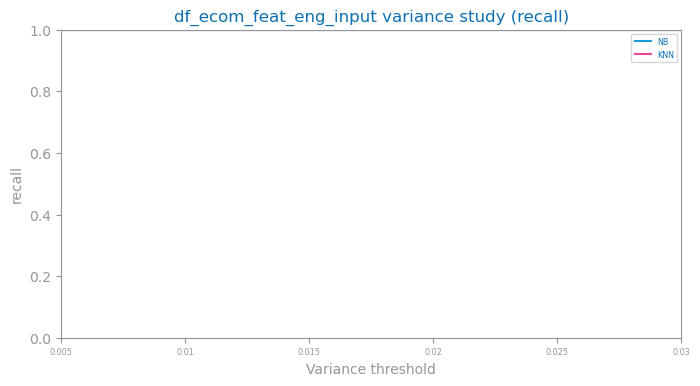

In [61]:
# modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)
if evaluate==True:

    eval_metric = "recall"
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_variance_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        max_threshold=0.03,
        lag=0.005,
        metric=eval_metric,
        file_tag=file_tag,
        min_features_to_keep = 10  # Minimum features safeguard

    )
    show()

### accuracy study

Testing threshold: 0.01
Dropping variables: ['time_of_day_sin']
Remaining features after drop: 16
Evaluation results at threshold 0.01: {'accuracy': [1.0, 0.9908256880733946], 'recall': [1.0, 1.0], 'precision': [1.0, 0.9819819819819819], 'auc': [1.0, 0.9908256880733946], 'f1': [1.0, 0.990909090909091]}
Evaluation for accuracy: [1.0, 0.9908256880733946]
Testing threshold: 0.02
Dropping variables: ['time_of_day_sin']
Remaining features after drop: 16
Evaluation results at threshold 0.02: {'accuracy': [1.0, 0.9908256880733946], 'recall': [1.0, 1.0], 'precision': [1.0, 0.9819819819819819], 'auc': [1.0, 0.9908256880733946], 'f1': [1.0, 0.990909090909091]}
Evaluation for accuracy: [1.0, 0.9908256880733946]
Testing threshold: 0.03
Dropping variables: ['time_of_day_sin']
Remaining features after drop: 16
Evaluation results at threshold 0.03: {'accuracy': [1.0, 0.9908256880733946], 'recall': [1.0, 1.0], 'precision': [1.0, 0.9819819819819819], 'auc': [1.0, 0.9908256880733946], 'f1': [1.0, 0.9909

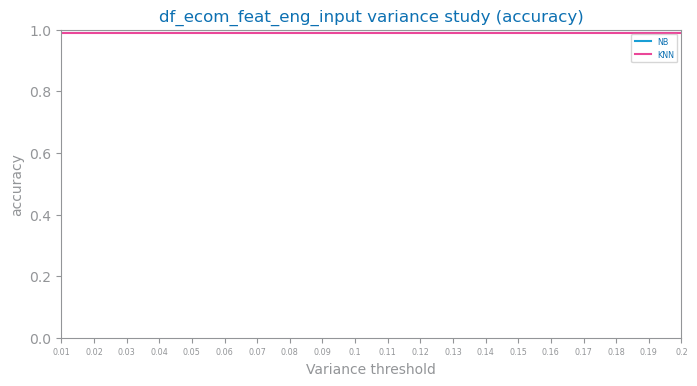

In [62]:
if evaluate==True:

    eval_metric = "accuracy"
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_variance_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        max_threshold=0.2,
        lag=0.01,
        metric=eval_metric,
        file_tag=file_tag,
        min_features_to_keep = 10  # Minimum features safeguard

    )
    show()

## Feat 1 strategy Application

## Feat 1 strategy Application

In [63]:
from pandas import DataFrame, Index

def apply_strategy_1(df: DataFrame) -> DataFrame:

    # this script is available in data_functions originally from DSLabs site in Feature Selection chapter

    df_copy=df.copy()
    
    vars2drop: list[str] = select_low_variance_variables(df_copy, max_threshold=0.03, min_features_to_keep=10, target=target)
    
    print("columns to drop:", vars2drop)

    df_vars_drop = df_copy.drop(columns=vars2drop, errors='ignore')
    
    print("Remaining columns:", df_vars_drop.columns)

    return df_vars_drop


df_1=apply_strategy_1(df)

df_1.describe()


Variance threshold: 0.03, Remaining features: 16
Variables to drop: ['time_of_day_sin']
columns to drop: ['time_of_day_sin']
Remaining columns: Index(['event_type', 'category_code_lvl_1', 'category_code_lvl_2',
       'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos', 'conversion'],
      dtype='object')


,event_type,category_code_lvl_1,category_code_lvl_2,category_code_lvl_3,price,week_of_month,is_weekend,day,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos,conversion
count,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000,14512.000000
mean,1.539462,0.143314,0.124076,0.115890,0.000182,-0.002414,0.020221,-0.015050,0.055160,-0.012105,-0.028976,0.099369,-0.069749,0.012757,0.001001,0.500000
std,1.761225,1.041309,1.022124,1.016511,0.968147,1.015880,1.010484,1.016010,0.987372,1.010204,1.011843,0.989492,0.975163,0.993220,1.006583,0.500017
min,-0.313392,-1.254962,-1.524222,-1.796606,-0.935681,-1.559001,-0.602010,-1.917360,-1.220425,-1.474230,-1.593781,-1.334503,-1.200070,-1.418465,-1.426252,0.000000
25%,-0.313392,-0.813563,-0.838341,-0.615633,-0.710305,-0.735420,-0.602010,-0.841817,-1.220425,-1.474230,-1.066318,-0.978530,-0.843266,-0.959641,-1.003598,0.000000
50%,3.192751,-0.151464,0.213344,0.356933,-0.321344,0.088162,-0.602010,-0.005283,0.819387,-0.162310,0.374836,0.177379,-0.111404,0.006456,0.088844,0.500000
75%,3.215657,1.393432,1.219302,1.167405,0.324036,0.911744,1.661102,0.831250,0.819387,0.798016,1.095413,1.085307,0.781435,1.026699,1.008572,1.000000
max,3.215657,1.393432,1.265028,1.306343,2.690135,1.735326,1.661102,1.548278,0.819387,1.149611,1.095413,1.326622,2.011654,1.431376,1.380676,1.000000


## Feat 1 train/test split 

Labels=[0, 1]


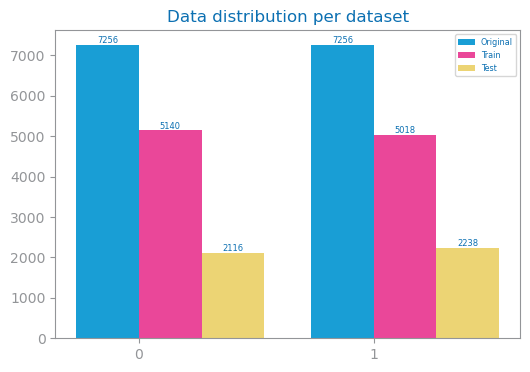

In [64]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    from numpy import array, ndarray


    y_1, X_1, labels, values = define_target_and_prepare_data(df_1, target)



    train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=df_1.columns), y_1, data_columns=df_1.columns, target_column=target)

    # Distribution check
    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Feat 1 evaluate

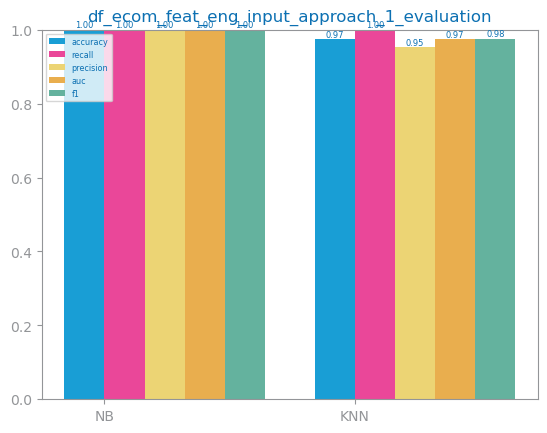

In [65]:
if evaluate==True:

    # evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
    # removed Multinomial from run_NB function because dataset has negative values

    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='conversion', metric="recall")
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_1_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_1_evaluation.png")
    show()

# Feat 2 - Dropping Redundant Variables


In [66]:


def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.1,
    lag: float = 0.03,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    # Generate the range of redundancy thresholds to test
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    # Ensure 'target' column is present and drop it for correlation calculation
    df: DataFrame = train.drop(target, axis=1, inplace=False)
    print(f"Columns in the train dataset: {df.columns.tolist()}")  # Debugging step

    # Calculate the correlation matrix
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    print(f"Variables considered for correlation: {variables.tolist()}")  # Debugging step

    results: dict[str, list] = {"NB": [], "KNN": []}
    
    for thresh in options:
        vars2drop: list = []
        
        # Loop through the variables to identify correlated features
        for v1 in variables:
            # Get features correlated with the current variable
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            
            # Check if the current variable is in the correlation list before trying to drop it
            if v1 in vars_corr:
                vars_corr.drop(v1, inplace=True)
            
            # If other variables are highly correlated with v1, consider them for removal
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        print(f"Variables to drop at threshold {thresh}: {vars2drop}")  # Debugging step
        
        # Drop the selected redundant variables from train and test datasets
        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)

        # Evaluate the approach using the current feature set
        eval: dict | None = evaluate_approach(train_copy, test_copy, target=target, metric=metric)

        # Check if evaluation returned results
        if eval:
            print(f"Evaluation results at threshold {thresh}: {eval}")
            if metric in eval:
                print(f"Evaluation for {metric}: {eval[metric]}")
                results["NB"].append(eval[metric][0])
                results["KNN"].append(eval[metric][1])
            else:
                print(f"Metric '{metric}' not found in evaluation results at threshold {thresh}.")
                results["NB"].append(None)
                results["KNN"].append(None)
        else:
            print(f"Evaluation failed or returned empty at threshold {thresh}.")
            results["NB"].append(None)
            results["KNN"].append(None)

    # Optional: Save or plot the results after evaluation
    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
    return results

In [211]:
test.columns

Index(['category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3',
       'price', 'week_of_month', 'is_weekend', 'day', 'is_view', 'is_cart',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'is_purchase'],
      dtype='object')

Columns in the train dataset: ['event_type', 'category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables considered for correlation: ['event_type', 'category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables to drop at threshold 0.001: ['category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'event_type']
Evaluation failed or returned empty at threshold 0.001.
Variables to drop at threshold 0.201: ['category_code_lvl_2', 'category_code_lvl_3', 'category_cod

TypeError: '<' not supported between instances of 'NoneType' and 'int'

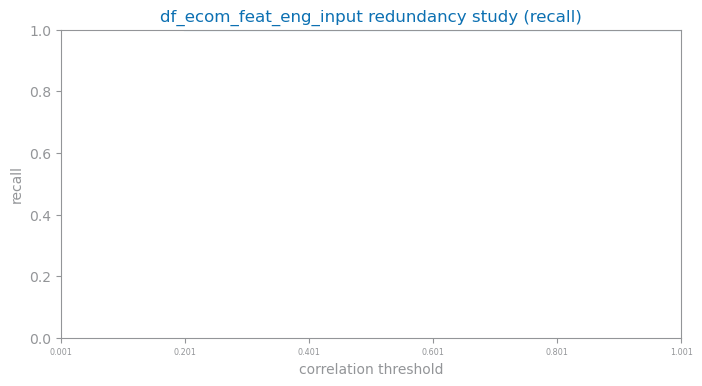

In [67]:
if evaluate==True:

    # modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)


    eval_metric = "recall"
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_redundancy_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        min_threshold = 0.001,
        lag = 0.2,
        metric=eval_metric,
        file_tag=file_tag,
    )
    show()

Columns in the train dataset: ['event_type', 'category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables considered for correlation: ['event_type', 'category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables to drop at threshold 0.05: ['category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3', 'day', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'event_type', 'price', 'week_of_month', 'is_weekend', 'day_of_week_sin', 'time_of_day_cos']
Evaluation results at threshold 0.05: {'accuracy': [0.5045871559633027, 0.5458715596330275], 'recall': [0.41509433962264153, 0.4811320754716981], 'precision': [0.488888888888888

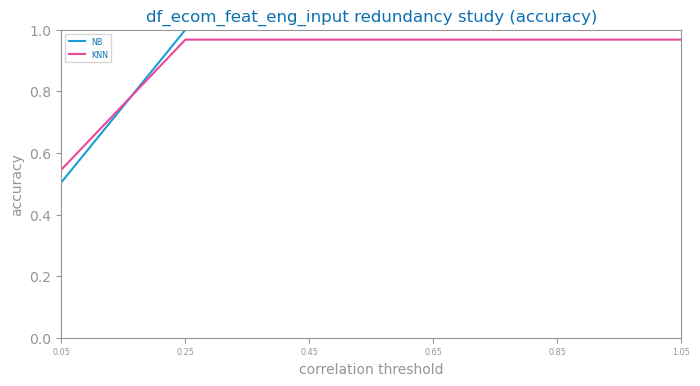

In [22]:
if evaluate==True:

    # modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)


    eval_metric = "accuracy"
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_redundancy_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        min_threshold = 0.05,
        lag = 0.2,
        metric=eval_metric,
        file_tag=file_tag,
    )
    show()

## Feat 2 - Study redundant variables and threshold

## Feat 2 strategy aplication

In [68]:
from pandas import DataFrame, Series

def select_redundant_variables(data: DataFrame, min_threshold: float = 1.5, target: str = "class") -> list:
    # Verifica se a coluna target existe no DataFrame
    if target not in data.columns:
        raise KeyError(f"Target column '{target}' not found in DataFrame.")
    
    # Remover espaços em branco dos nomes das colunas
    data.columns = data.columns.str.strip()

    # Copiar o DataFrame e remover a coluna target
    df: DataFrame = data.drop(target, axis=1, inplace=False)

    # Calcular a matriz de correlação absoluta
    corr_matrix: DataFrame = abs(df.corr())
    
    # Lista de variáveis a remover
    vars2drop: list = []

    # Obter as colunas do DataFrame
    variables: Index[str] = corr_matrix.columns

    # Iterar sobre as variáveis
    for v1 in variables:
        vars_corr: Series = corr_matrix[v1].loc[corr_matrix[v1] >= min_threshold]

        # Remover a autocorrelação (com a própria variável)
        vars_corr = vars_corr.drop(v1, errors='ignore')

        # Verificar se há mais de uma correlação forte
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)

            # Adicionar variáveis correlacionadas à lista de remoção, se ainda não estiverem
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)

    return vars2drop


In [69]:
def apply_strategy_2(df):
    df_copy = df.copy()

    # Garantir que a coluna 'is_purchase' não será removida
    vars2drop = select_redundant_variables(df_copy, min_threshold=0.9, target=target)
    print("columns to drop:", vars2drop)

    # Remover variáveis redundantes, mas garantir que 'is_purchase' não é removida
    df_vars_drop = df_copy.drop(columns=[col for col in vars2drop if col != 'is_purchase'], errors='ignore')
    
    print("Remaining columns:", df_vars_drop.columns)

    return df_vars_drop

df_2=df.copy()

df_2=apply_strategy_2(df_2)

columns to drop: ['category_code_lvl_2', 'category_code_lvl_3', 'category_code_lvl_1']
Remaining columns: Index(['event_type', 'price', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'conversion'],
      dtype='object')


In [53]:
print(df_2.columns)


Index(['event_type', 'price', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'conversion'],
      dtype='object')


## Feat 2 train/test split 

Labels=[0, 1]


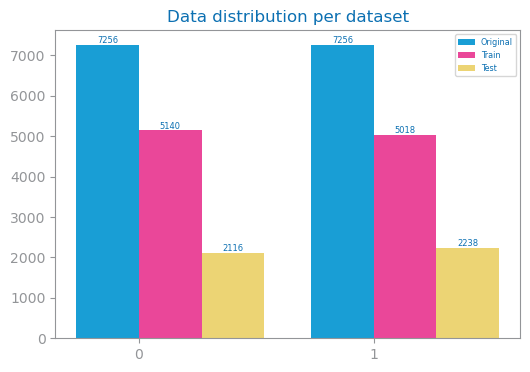

In [70]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    from numpy import array, ndarray


    y_2, X_2, labels, values = define_target_and_prepare_data(df_2, target)



    train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=df_2.columns), y_2, data_columns=df_2.columns, target_column=target)

    # Distribution check
    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Feat 2 evaluate

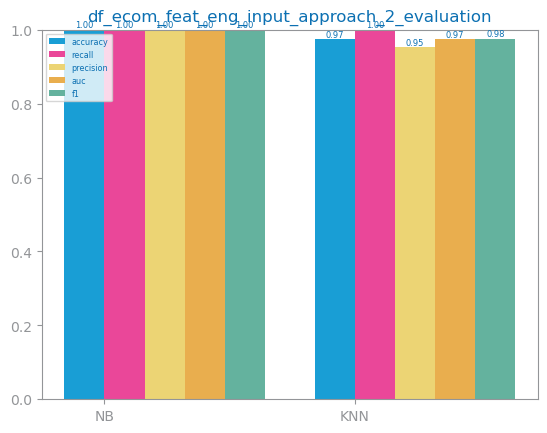

In [71]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='conversion', metric="recall")
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag}_approach_2_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_2_evaluation.png")
    show()

# Approach uplift comparison

## uplift df

In [72]:
if evaluate == True:
    
    algorithms = ['Naive Bayes', 'KNN']

    # Create DataFrames for eval_1 and eval_2
    df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
    df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

    # Calculate uplift
    df_uplift = df_eval_2 - df_eval_1



    # Combine everything into one DataFrame (without misalignment issues)
    comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
    comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



    # Display the DataFrame
    display(comparison_df)

Approach 1                                      Approach 2         \
              accuracy recall precision       auc        f1   accuracy recall   
Naive Bayes   1.000000    1.0  1.000000  1.000000  1.000000   1.000000    1.0   
KNN           0.974506    1.0  0.952746  0.973771  0.975801   0.974506    1.0   

                                            Uplift                             
            precision       auc        f1 accuracy recall precision  auc   f1  
Naive Bayes  1.000000  1.000000  1.000000      0.0    0.0       0.0  0.0  0.0  
KNN          0.952746  0.973771  0.975801      0.0    0.0       0.0  0.0  0.0

# Analysis

- NB (better on approach 2): 
    - Scale1 accuracy 0.33, recall 0.87, auc 0.51
    - scale2 accuracy 0.43 recall 0.82, auc 0.56
- KNN: no significant uplifts between approaches
- overall scale 2 vs outliers treatment
    - very significant improved recall
    - significant accuracy loss


# save to csv

In [74]:
if test_data==False:
    
    
    data_save=df.copy()

    data_save=apply_strategy_1(data_save)
        
    data_save.to_csv(f"dataset/df_ecom_2_5_feat_eng_input_v2.csv", index=False)


    print(data_save.columns)



Variance threshold: 0.03, Remaining features: 16
Variables to drop: ['time_of_day_sin']
columns to drop: ['time_of_day_sin']
Remaining columns: Index(['event_type', 'category_code_lvl_1', 'category_code_lvl_2',
       'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos', 'conversion'],
      dtype='object')
Index(['event_type', 'category_code_lvl_1', 'category_code_lvl_2',
       'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos', 'conversion'],
      dtype='object')


## train test csv

In [75]:
if test_data==False:
    

    data_save_copy=data_save.copy()

    
    y, X, labels, class_counts = define_target_and_prepare_data(data_save_copy, target=target)

    train, test = split_data_save_csv(pd.DataFrame(X, columns=data_save_copy.columns), y, data_columns=data_save_copy.columns, target_column=target)  
    
    train.to_csv(f"dataset/df_ecom_2_5_feat_eng_input_v2_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"dataset/df_ecom_2_5_feat_eng_input_v2_test.csv", index=False)
    print(test.columns)

Labels=[0, 1]
Index(['event_type', 'category_code_lvl_1', 'category_code_lvl_2',
       'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos', 'conversion'],
      dtype='object')
Index(['event_type', 'category_code_lvl_1', 'category_code_lvl_2',
       'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos', 'conversion'],
      dtype='object')
